# Naive Bayes - Trained on the Sentiment 140 data set
In this section we'll attempt to build a custom Naive Bayes model for text classification. Naive Bayes classifiers use conditional probabilities based on pre-tagged data, so weWill use pre-tagged data set containing about 1.6 million tweets tagged for negative, positive, and neutral sentiment. Try training and running a multinomial Naive Bayes model from sklearn. To "vectorize" the text, we must first apply a TFIDF (term-frequency/inverse document frequency) transformation to model the text values as numeric values.

https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download

In [20]:
import os
import pandas as pd
from comment_scraper import get_sql_table
from matplotlib import pyplot as plt
plt.style.use('seaborn-notebook')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer # tweet tokenizer is good for handling common words/symbols/emoticons found in social media data
from nltk.corpus import stopwords
from nltk.tag import pos_tag

In [21]:
DATA_DIR = 'C:\\Users\\keatu\\Regis_archive\\practicum2_data\\'
dbname = os.path.join(DATA_DIR, "Youtube_Data_msnbc.db")

In [12]:
colnames = ["target","id","date","flag","user","text"]
s140_test = pd.read_csv(os.path.join(DATA_DIR,"resources","s140_test.csv"), names = colnames)
s140_train = pd.read_csv(os.path.join(DATA_DIR,"resources","s140_train.csv"), names = colnames, encoding='latin-1')

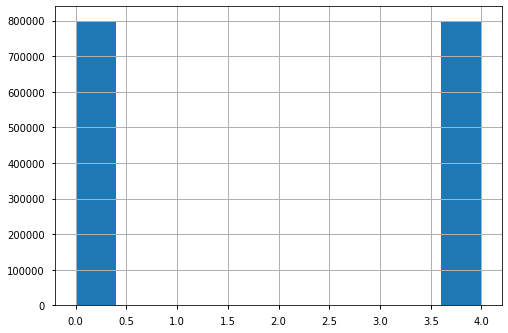

In [13]:
# lookt at distribution
s140_train['target'].hist()
plt.show()

In [23]:
# create the data pre-processing function that will be applied to each text string
def clean_data(text):
    #stopwords = stopwords.words('english')
    lemmatizer = WordNetLemmatizer()
    tokenizer = TweetTokenizer()
    text_vector = []
    for each_text in text:
        lemmatized_tokens = []
        tokens=tokenizer.tokenize(each_text.lower())
        pos_tags=pos_tag(tokens)
        for each_token, tag in pos_tags: 
            if tag.startswith('NN'): 
                pos='n'
            elif tag.startswith('VB'): 
                pos='v'
            else: 
                pos='a'
            lemmatized_token=lemmatizer.lemmatize(each_token, pos)
            lemmatized_tokens.append(lemmatized_token)
        text_vector.append(' '.join(lemmatized_tokens))
    return text_vector

In [24]:
clean_data("I love movies")

['i', '', 'l', 'o', 'v', 'e', '', 'm', 'o', 'v', 'i', 'e', 's']

In [25]:
estimators=[('cleaner', FunctionTransformer(clean_data)), 
            ('vectorizer', TfidfVectorizer(max_features=100000, ngram_range=(1, 2)))]
preprocessing_pipeline=Pipeline(estimators)

In [30]:
help(TfidfVectorizer)

Help on class TfidfVectorizer in module sklearn.feature_extraction.text:

class TfidfVectorizer(CountVectorizer)
 |  TfidfVectorizer(input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, analyzer='word', stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.float64'>, norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
 |  
 |  Convert a collection of raw documents to a matrix of TF-IDF features.
 |  
 |  Equivalent to :class:`CountVectorizer` followed by
 |  :class:`TfidfTransformer`.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  ----------
 |  input : string {'filename', 'file', 'content'}
 |      If 'filename', the sequence passed as an argument to fit is
 |      expected to be a list of filenames that need reading to fetch
 |      the raw con

In [27]:
X=s140_train['text']
y=s140_train['target']
X_train, X_test, y_train, y_test=train_test_split(X, y)

In [28]:
X_train

188061     I hate the internet tonight. It ruined everyth...
992770     @pandamerv yeah! I'm listening to it right now...
834725     @Shinybiscuit lemme know when tweaked, and I'l...
541887     I'm upset  I can't find @ddlovato and @selenag...
1127231    In indiana at the pinks all out show!  these c...
                                 ...                        
979613     @iamxc You can also play Tongits on your PC or...
1413945                @Flyestoncampus come to my job dweeb 
539939                    the weather is killing me too hot 
1527359    wahahah playing sims 3 online but theres less ...
1058393    your adv banner/page for FREE in my magazine! ...
Name: text, Length: 1200000, dtype: object

In [29]:
# Fit and transform the pipeline
X_train_transformed=preprocessing_pipeline.fit_transform(X_train)

c:\Users\keatu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:179: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(joblib_version) < '0.12':
c:\Users\keatu\Anaconda3\lib\site-packages\sklearn\preprocessing\_function_transformer.py:97: FutureWarning: The default validate=True will be replaced by validate=False in 0.22.
  "validate=False in 0.22.", FutureWarning)


ValueError: could not convert string to float: 'I hate the internet tonight. It ruined everything '